In [1]:
!nvidia-smi

Fri Dec  8 14:08:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P8                3W /  N/A|    692MiB /  8188MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Model Setting

In [2]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

class ParallelSum(nn.Module):
    def __init__(self, *fns):
        super().__init__()
        self.fns = nn.ModuleList(fns)

    def forward(self, x):
        return sum(map(lambda fn: fn(x), self.fns))

def Permutator(*, image_size, patch_size, dim, depth, num_classes, segments, expansion_factor = 2, dropout = 0.):
    assert (image_size % patch_size) == 0, 'image must be divisible by patch size'
    assert (dim % segments) == 0, 'dimension must be divisible by the number of segments'
    height = width = image_size // patch_size
    s = segments

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * 3, dim),
        *[nn.Sequential(
            PreNormResidual(dim, nn.Sequential(
                ParallelSum(
                    nn.Sequential(
                        Rearrange('b h w (c s) -> b w c (h s)', s = s),
                        nn.Linear(height * s, height * s),
                        Rearrange('b w c (h s) -> b h w (c s)', s = s),
                    ),
                    nn.Sequential(
                        Rearrange('b h w (c s) -> b h c (w s)', s = s),
                        nn.Linear(width * s, width * s),
                        Rearrange('b h c (w s) -> b h w (c s)', s = s),
                    ),
                    nn.Linear(dim, dim)
                ),
                nn.Linear(dim, dim)
            )),
            PreNormResidual(dim, nn.Sequential(
                nn.Linear(dim, dim * expansion_factor),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(dim * expansion_factor, dim),
                nn.Dropout(dropout)
            ))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b h w c -> b c', 'mean'),
        nn.Linear(dim, num_classes)
    )

In [3]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 2, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 2, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes)
    )

In [16]:
import torch
import numpy as np
#import MLPMixer
# here we try different patch_size
model = MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 14,
    dim = 196,
    depth = 2,
    num_classes = 15
)

img = torch.randn(1, 3, 224, 224)
'''
pred = model(img) # (1, 1000)
print(pred.argmax())
'''
parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)
out_img = model(img)
print("Shape of out :", out_img.shape)  # [B, in_channels, image_size, image_size]

Trainable Parameters: 0.724M
Shape of out : torch.Size([1, 15])


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# data directory
data_dir = './Dataset'

# data preprocessing, no data argumentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# training set
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)

# test set
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)

# validation set
validation_dataset = datasets.ImageFolder(root=data_dir + '/validation', transform=transform)

# data loader
batch_size = 128  # based on hardware
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [19]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Basic Model

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
#print(device)

Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=14, p2=14)
  (1): Linear(in_features=588, out_features=196, bias=True)
  (2): Sequential(
    (0): PreNormResidual(
      (fn): Sequential(
        (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
    )
    (1): PreNormResidual(
      (fn): Sequential(
        (0): Linear(in_features=196, out_features=98, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=98, out_features=196, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
    )
  )
  (3): Sequential(
    (0): PreNormResidual(
      (fn): Sequential(

In [21]:
train_losses = []
val_losses = []
val_accuracies = []


In [22]:
num_epochs=20
criterion = nn.CrossEntropyLoss()
cur_lr=0.001
optimizer = optim.Adam(model.parameters(), lr=cur_lr)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        model.eval()
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(validation_loader))
    val_accuracies.append(val_correct / val_total)

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}')

    # 保存训练后的模型
    torch.save(model.state_dict(), 'mlp_mixer_vegetables.pth')


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:39<00:00,  1.18it/s]


Epoch 1, Train Loss: 1.6607681517883883, Validation Loss: 0.9644322767853737, Validation Accuracy: 0.688


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:36<00:00,  1.23it/s]


Epoch 2, Train Loss: 0.7173645829750319, Validation Loss: 0.5503654250254234, Validation Accuracy: 0.836


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:14<00:00,  1.59it/s]


Epoch 3, Train Loss: 0.4132247437107361, Validation Loss: 0.39626858693857986, Validation Accuracy: 0.8716666666666667


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:14<00:00,  1.59it/s]


Epoch 4, Train Loss: 0.25058415254293864, Validation Loss: 0.3122980942328771, Validation Accuracy: 0.895


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:13<00:00,  1.61it/s]


Epoch 5, Train Loss: 0.19891014186886408, Validation Loss: 0.24894358776509762, Validation Accuracy: 0.9203333333333333


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:12<00:00,  1.62it/s]


Epoch 6, Train Loss: 0.13832263664295108, Validation Loss: 0.21200674345406392, Validation Accuracy: 0.931


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:12<00:00,  1.62it/s]


Epoch 7, Train Loss: 0.10116880914291083, Validation Loss: 0.16324478690512478, Validation Accuracy: 0.9523333333333334


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:13<00:00,  1.61it/s]


Epoch 8, Train Loss: 0.09174989185974759, Validation Loss: 0.20215450902469456, Validation Accuracy: 0.9333333333333333


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:12<00:00,  1.63it/s]


Epoch 9, Train Loss: 0.07668972479463634, Validation Loss: 0.17519622800561288, Validation Accuracy: 0.9463333333333334


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:12<00:00,  1.63it/s]


Epoch 10, Train Loss: 0.05871069810148013, Validation Loss: 0.186956343629087, Validation Accuracy: 0.946


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:12<00:00,  1.62it/s]


Epoch 11, Train Loss: 0.03494135025983392, Validation Loss: 0.16274981177411973, Validation Accuracy: 0.952


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:12<00:00,  1.62it/s]


Epoch 12, Train Loss: 0.047646269628430826, Validation Loss: 0.218433673804005, Validation Accuracy: 0.938


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:14<00:00,  1.59it/s]


Epoch 13, Train Loss: 0.052019529920702766, Validation Loss: 0.13424129077854255, Validation Accuracy: 0.9586666666666667


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:16<00:00,  1.54it/s]


Epoch 14, Train Loss: 0.03577969804153604, Validation Loss: 0.2428635136845211, Validation Accuracy: 0.933


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:14<00:00,  1.58it/s]


Epoch 15, Train Loss: 0.05415672497918545, Validation Loss: 0.15506332996301353, Validation Accuracy: 0.9566666666666667


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:14<00:00,  1.59it/s]


Epoch 16, Train Loss: 0.061320178629041225, Validation Loss: 0.20582720250240527, Validation Accuracy: 0.945


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:13<00:00,  1.60it/s]


Epoch 17, Train Loss: 0.03390253906461836, Validation Loss: 0.1300215083368433, Validation Accuracy: 0.962


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:14<00:00,  1.59it/s]


Epoch 18, Train Loss: 0.010042539146586748, Validation Loss: 0.11507183608288567, Validation Accuracy: 0.9676666666666667


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:15<00:00,  1.56it/s]


Epoch 19, Train Loss: 0.02317559300385163, Validation Loss: 0.12774000006417432, Validation Accuracy: 0.9633333333333334


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:14<00:00,  1.58it/s]


Epoch 20, Train Loss: 0.00850136362714693, Validation Loss: 0.0966029889677884, Validation Accuracy: 0.975


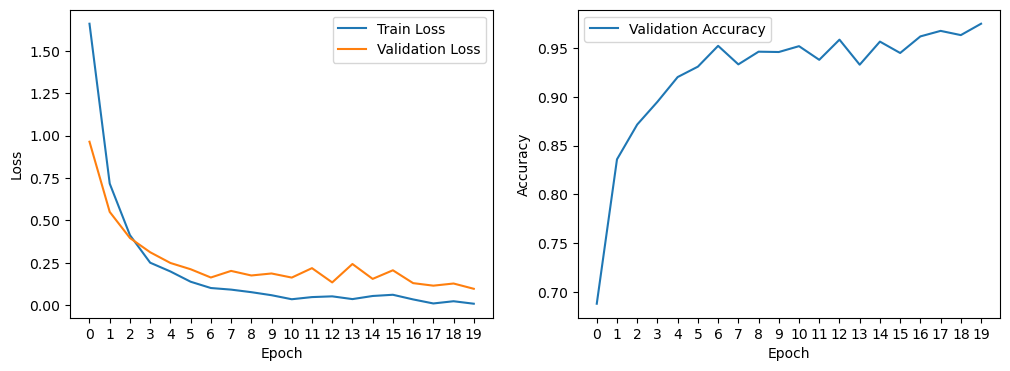

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(num_epochs))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(num_epochs))
plt.legend()
plt.show()


In [ ]:

# load model weight
model = MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 14,
    dim = 196,
    depth = 2,
    num_classes = 15
)

model.load_state_dict(torch.load('./mlp_mixer_vegetables.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()


test_accuracy = test_correct / test_total
print(f'Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy}')


# Base Model with Different Patch Size

We try to explore the influence patch size may cause to the model.

There are different patch size: 8, 14, 28, 32, 56

In [9]:
# prepare dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# data directory
data_dir = './Dataset'

# data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# training set
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)

# test set
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)

# validation set
validation_dataset = datasets.ImageFolder(root=data_dir + '/validation', transform=transform)

# data loader
batch_size = 128  # based on hardware
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [10]:
train_loss_8 = []
val_loss_8 = []
val_acc_8 = []
train_loss_14 = []
val_loss_14 = []
val_acc_14 = []
train_loss_28 = []
val_loss_28 = []
val_acc_28 = []
train_loss_32 = []
val_loss_32 = []
val_acc_32 = []
train_loss_56 = []
val_loss_56 = []
val_acc_56 = []

In [11]:
# train certain model
num_epochs=50
def train_model(model, train_losses, val_losses, val_accuracies, model_name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    #num_epochs=50
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # validation loss and validation acc
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            model.eval()
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(validation_loader))
        val_accuracies.append(val_correct / val_total)
        
        print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}')

    # save model weight
    torch.save(model.state_dict(), f'mlp_mixer_vegetables_{model_name}.pth')

In [12]:
# test certain model
def test_model(model,model_name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f'Patch size: {model_name}, Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy}')

In [13]:
# polt results
def plt_model(train_losses, val_losses, val_accuracies, patch_size):
    print("patch size=",patch_size)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [14]:
image_h=224
m_8=MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 8,
    dim = image_h//8,
    depth = 2,
    num_classes = 15
)

m_14=MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 14,
    dim = image_h//14,
    depth = 2,
    num_classes = 15
)

m_28=MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 28,
    dim = image_h//28,
    depth = 2,
    num_classes = 15
)

m_32=MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 32,
    dim = image_h//32,
    depth = 2,
    num_classes = 15
)

m_56=MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 56,
    dim = image_h//56,
    depth = 2,
    num_classes = 15
)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.37it/s]


Epoch 1, Train Loss: 2.7471965874655773, Validation Loss: 2.6791648070017495, Validation Accuracy: 0.048666666666666664


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.49it/s]


Epoch 2, Train Loss: 2.613638651573052, Validation Loss: 2.548389822244644, Validation Accuracy: 0.16566666666666666


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.44it/s]


Epoch 3, Train Loss: 2.4443299669330405, Validation Loss: 2.4209146996339164, Validation Accuracy: 0.17566666666666667


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.43it/s]


Epoch 4, Train Loss: 2.2631084413851723, Validation Loss: 2.1808565855026245, Validation Accuracy: 0.2613333333333333


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.46it/s]


Epoch 5, Train Loss: 2.135973717196513, Validation Loss: 2.1160614093144736, Validation Accuracy: 0.25566666666666665


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 6, Train Loss: 2.019476910768929, Validation Loss: 2.008634259303411, Validation Accuracy: 0.3016666666666667


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.47it/s]


Epoch 7, Train Loss: 1.9472205719705356, Validation Loss: 1.9498458504676819, Validation Accuracy: 0.32666666666666666


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.48it/s]


Epoch 8, Train Loss: 1.9017856474650108, Validation Loss: 1.9577390402555466, Validation Accuracy: 0.315


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 9, Train Loss: 1.8649847931781058, Validation Loss: 1.9467926919460297, Validation Accuracy: 0.32233333333333336


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.46it/s]


Epoch 10, Train Loss: 1.85504999504251, Validation Loss: 1.8694383452335994, Validation Accuracy: 0.36133333333333334


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.21it/s]


Epoch 11, Train Loss: 1.8078713750435134, Validation Loss: 1.9044150734941165, Validation Accuracy: 0.338


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.47it/s]


Epoch 12, Train Loss: 1.78515312328177, Validation Loss: 1.8540332714716594, Validation Accuracy: 0.35733333333333334


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.44it/s]


Epoch 13, Train Loss: 1.7636866640236417, Validation Loss: 1.8484770953655243, Validation Accuracy: 0.3536666666666667


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.29it/s]


Epoch 14, Train Loss: 1.7749421798576743, Validation Loss: 1.8245557770133018, Validation Accuracy: 0.36866666666666664


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.51it/s]


Epoch 15, Train Loss: 1.7237385076991583, Validation Loss: 1.81122491757075, Validation Accuracy: 0.366


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.53it/s]


Epoch 16, Train Loss: 1.7077913092354597, Validation Loss: 1.7751860866943996, Validation Accuracy: 0.38233333333333336


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.46it/s]


Epoch 17, Train Loss: 1.6920372975074638, Validation Loss: 1.752725360294183, Validation Accuracy: 0.39866666666666667


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 18, Train Loss: 1.671340958546784, Validation Loss: 1.803863264620304, Validation Accuracy: 0.364


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.38it/s]


Epoch 19, Train Loss: 1.6887115250199527, Validation Loss: 1.7330786834160488, Validation Accuracy: 0.395


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.41it/s]


Epoch 20, Train Loss: 1.653432273258597, Validation Loss: 1.7437311485409737, Validation Accuracy: 0.39566666666666667


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.48it/s]


Epoch 21, Train Loss: 1.638719855728796, Validation Loss: 1.8091033125917118, Validation Accuracy: 0.36833333333333335


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.47it/s]


Epoch 22, Train Loss: 1.6388788506136103, Validation Loss: 1.7191468601425488, Validation Accuracy: 0.4066666666666667


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 23, Train Loss: 1.6239553568726879, Validation Loss: 1.7026081879933674, Validation Accuracy: 0.416


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.52it/s]


Epoch 24, Train Loss: 1.6100505095417217, Validation Loss: 1.7329617490371068, Validation Accuracy: 0.38966666666666666


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.49it/s]


Epoch 25, Train Loss: 1.5998163102036815, Validation Loss: 1.7023966958125432, Validation Accuracy: 0.406


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.48it/s]


Epoch 26, Train Loss: 1.5993088362580639, Validation Loss: 1.7506205514073372, Validation Accuracy: 0.3963333333333333


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.43it/s]


Epoch 27, Train Loss: 1.5852047497943296, Validation Loss: 1.7034112562735875, Validation Accuracy: 0.411


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.49it/s]


Epoch 28, Train Loss: 1.5700538936307875, Validation Loss: 1.6991759737332661, Validation Accuracy: 0.4066666666666667


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.45it/s]


Epoch 29, Train Loss: 1.5826704148518838, Validation Loss: 1.697070005039374, Validation Accuracy: 0.409


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.51it/s]


Epoch 30, Train Loss: 1.5542576383736173, Validation Loss: 1.681863971054554, Validation Accuracy: 0.412


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 31, Train Loss: 1.5377280116081238, Validation Loss: 1.7030315573016803, Validation Accuracy: 0.4176666666666667


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.45it/s]


Epoch 32, Train Loss: 1.5289524227885876, Validation Loss: 1.6708310792843502, Validation Accuracy: 0.41933333333333334


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 33, Train Loss: 1.517841118877217, Validation Loss: 1.660432606935501, Validation Accuracy: 0.424


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.48it/s]


Epoch 34, Train Loss: 1.5285032149088584, Validation Loss: 1.6503981997569401, Validation Accuracy: 0.43366666666666664


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 35, Train Loss: 1.5307254316443104, Validation Loss: 1.6691226239005725, Validation Accuracy: 0.41133333333333333


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 36, Train Loss: 1.4907179979954737, Validation Loss: 1.6430654774109523, Validation Accuracy: 0.43133333333333335


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.46it/s]


Epoch 37, Train Loss: 1.5002639667462494, Validation Loss: 1.631712647775809, Validation Accuracy: 0.44466666666666665


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.45it/s]


Epoch 38, Train Loss: 1.5044767654548257, Validation Loss: 1.6602330729365349, Validation Accuracy: 0.4146666666666667


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.38it/s]


Epoch 39, Train Loss: 1.4728173603445798, Validation Loss: 1.6581966703136761, Validation Accuracy: 0.42766666666666664


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.44it/s]


Epoch 40, Train Loss: 1.4886371018522877, Validation Loss: 1.6279173716902733, Validation Accuracy: 0.43833333333333335


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.44it/s]


Epoch 41, Train Loss: 1.4699387408919253, Validation Loss: 1.647158329685529, Validation Accuracy: 0.43033333333333335


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.45it/s]


Epoch 42, Train Loss: 1.4900584938162464, Validation Loss: 1.6034688353538513, Validation Accuracy: 0.4563333333333333


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.49it/s]


Epoch 43, Train Loss: 1.4516259876348205, Validation Loss: 1.6029560243089993, Validation Accuracy: 0.44866666666666666


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.45it/s]


Epoch 44, Train Loss: 1.4406697719784107, Validation Loss: 1.7174610247214634, Validation Accuracy: 0.40066666666666667


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.45it/s]


Epoch 45, Train Loss: 1.4623501644296162, Validation Loss: 1.6190584438542526, Validation Accuracy: 0.44266666666666665


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.50it/s]


Epoch 46, Train Loss: 1.4304582517025834, Validation Loss: 1.592802199224631, Validation Accuracy: 0.4503333333333333


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.44it/s]


Epoch 47, Train Loss: 1.4289239200495056, Validation Loss: 1.601188230017821, Validation Accuracy: 0.45266666666666666


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.48it/s]


Epoch 48, Train Loss: 1.4112530643657102, Validation Loss: 1.6541307953496773, Validation Accuracy: 0.43466666666666665


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.55it/s]


Epoch 49, Train Loss: 1.4172873901108565, Validation Loss: 1.6662351066867511, Validation Accuracy: 0.44433333333333336


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.54it/s]


Epoch 50, Train Loss: 1.4181005065724002, Validation Loss: 1.7358559258282185, Validation Accuracy: 0.413
Patch size: 56, Test Loss: 1.7188709924618404, Test Accuracy: 0.425
patch size= 56


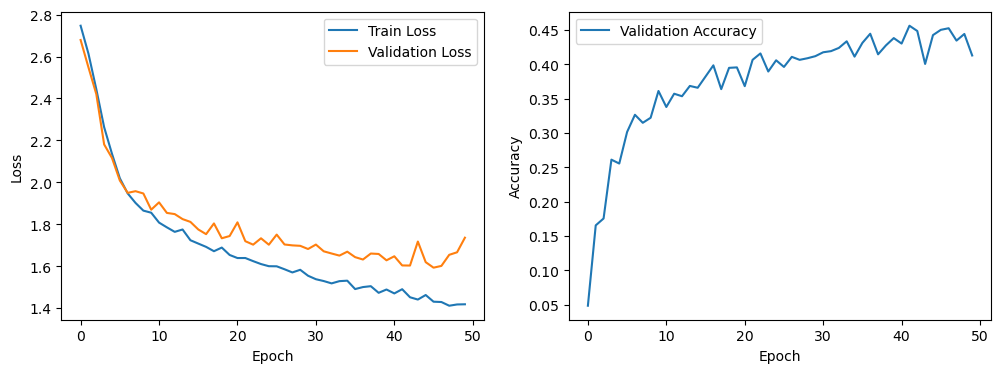

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.90it/s]


Epoch 1, Train Loss: 2.725886199433925, Validation Loss: 2.6589528818925223, Validation Accuracy: 0.137


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.86it/s]


Epoch 2, Train Loss: 2.4463102514460937, Validation Loss: 2.22226220369339, Validation Accuracy: 0.27466666666666667


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.83it/s]


Epoch 3, Train Loss: 2.0626079955343473, Validation Loss: 1.9660371964176495, Validation Accuracy: 0.336


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.90it/s]


Epoch 4, Train Loss: 1.8170905052605322, Validation Loss: 1.7724119648337364, Validation Accuracy: 0.43633333333333335


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.06it/s]


Epoch 5, Train Loss: 1.6465069196992002, Validation Loss: 1.5862661252419155, Validation Accuracy: 0.48933333333333334


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.03it/s]


Epoch 6, Train Loss: 1.5141982628127275, Validation Loss: 1.5137795756260555, Validation Accuracy: 0.5103333333333333


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.06it/s]


Epoch 7, Train Loss: 1.4297597499217016, Validation Loss: 1.3967630142966907, Validation Accuracy: 0.5523333333333333


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.06it/s]


Epoch 8, Train Loss: 1.3363157823934393, Validation Loss: 1.3252729525168736, Validation Accuracy: 0.5766666666666667


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.04it/s]


Epoch 9, Train Loss: 1.2653238429861553, Validation Loss: 1.3191751912236214, Validation Accuracy: 0.574


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.00it/s]


Epoch 10, Train Loss: 1.2158561763116869, Validation Loss: 1.2946760232249896, Validation Accuracy: 0.5746666666666667


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.06it/s]


Epoch 11, Train Loss: 1.1677443506353993, Validation Loss: 1.232133003572623, Validation Accuracy: 0.609


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.05it/s]


Epoch 12, Train Loss: 1.126812065556898, Validation Loss: 1.1318973215917747, Validation Accuracy: 0.642


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.04it/s]


Epoch 13, Train Loss: 1.0716768361754336, Validation Loss: 1.147437001268069, Validation Accuracy: 0.621


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.08it/s]


Epoch 14, Train Loss: 1.036205427626432, Validation Loss: 1.0953418103357155, Validation Accuracy: 0.6463333333333333


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.09it/s]


Epoch 15, Train Loss: 0.9974163169577971, Validation Loss: 1.04376586774985, Validation Accuracy: 0.6713333333333333


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.04it/s]


Epoch 16, Train Loss: 0.9647432222204694, Validation Loss: 1.077351437881589, Validation Accuracy: 0.6453333333333333


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.07it/s]


Epoch 17, Train Loss: 0.9446745363332457, Validation Loss: 1.024662176767985, Validation Accuracy: 0.6843333333333333


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.05it/s]


Epoch 18, Train Loss: 0.9069746944863918, Validation Loss: 1.0094186291098595, Validation Accuracy: 0.692


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.07it/s]


Epoch 19, Train Loss: 0.8815644297559383, Validation Loss: 0.970176183929046, Validation Accuracy: 0.6943333333333334


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.03it/s]


Epoch 20, Train Loss: 0.8645793805688115, Validation Loss: 1.0029908356567223, Validation Accuracy: 0.6776666666666666


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.09it/s]


Epoch 21, Train Loss: 0.842849066701986, Validation Loss: 1.000755009551843, Validation Accuracy: 0.6863333333333334


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.07it/s]


Epoch 22, Train Loss: 0.838947864912324, Validation Loss: 0.9622643801073233, Validation Accuracy: 0.6873333333333334


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.06it/s]


Epoch 23, Train Loss: 0.785683656648054, Validation Loss: 1.0055571204672258, Validation Accuracy: 0.6813333333333333


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.09it/s]


Epoch 24, Train Loss: 0.7677225051289898, Validation Loss: 0.8916539611915747, Validation Accuracy: 0.7326666666666667


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.10it/s]


Epoch 25, Train Loss: 0.7372314778424925, Validation Loss: 0.8784514032304287, Validation Accuracy: 0.7356666666666667


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.07it/s]


Epoch 26, Train Loss: 0.746548135906963, Validation Loss: 0.9238529329498609, Validation Accuracy: 0.6926666666666667


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.04it/s]


Epoch 27, Train Loss: 0.7268651031841666, Validation Loss: 0.8828299567103386, Validation Accuracy: 0.723


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.02it/s]


Epoch 28, Train Loss: 0.706210895615109, Validation Loss: 0.9033183467884859, Validation Accuracy: 0.7273333333333334


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.06it/s]


Epoch 29, Train Loss: 0.6623057563931255, Validation Loss: 0.8533129543066025, Validation Accuracy: 0.74


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.03it/s]


Epoch 30, Train Loss: 0.6616317018613977, Validation Loss: 0.8533919776479403, Validation Accuracy: 0.7413333333333333


Epoch 31: 100%|███████████████████████████████████████████████████████████████████| 118/118 [5:11:41<00:00, 158.49s/it]


Epoch 31, Train Loss: 0.6513565319069361, Validation Loss: 0.8791520055383444, Validation Accuracy: 0.735


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.84it/s]


Epoch 32, Train Loss: 0.6229496416399034, Validation Loss: 0.8272877161701521, Validation Accuracy: 0.7453333333333333


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.82it/s]


Epoch 33, Train Loss: 0.6171381385144541, Validation Loss: 0.8632425597558419, Validation Accuracy: 0.7446666666666667


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.03it/s]


Epoch 34, Train Loss: 0.6037985323849371, Validation Loss: 0.8968962623427311, Validation Accuracy: 0.732


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.99it/s]


Epoch 35, Train Loss: 0.5780518600496195, Validation Loss: 0.9007761118312677, Validation Accuracy: 0.7256666666666667


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.01it/s]


Epoch 36, Train Loss: 0.5849946045269401, Validation Loss: 0.8111345519622167, Validation Accuracy: 0.7633333333333333


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.08it/s]


Epoch 37, Train Loss: 0.546095432618917, Validation Loss: 0.7666725938518842, Validation Accuracy: 0.7793333333333333


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.06it/s]


Epoch 38, Train Loss: 0.5476543817479732, Validation Loss: 0.8181713366260132, Validation Accuracy: 0.7556666666666667


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.01it/s]


Epoch 39, Train Loss: 0.5327268914651062, Validation Loss: 0.8200643000503381, Validation Accuracy: 0.768


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.09it/s]


Epoch 40, Train Loss: 0.5328851334624372, Validation Loss: 0.7863810118287802, Validation Accuracy: 0.77


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.98it/s]


Epoch 41, Train Loss: 0.5039976320024264, Validation Loss: 0.8489347019543251, Validation Accuracy: 0.7463333333333333


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.09it/s]


Epoch 42, Train Loss: 0.513854005074097, Validation Loss: 0.8374014732738336, Validation Accuracy: 0.7596666666666667


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.02it/s]


Epoch 43, Train Loss: 0.49348953416792013, Validation Loss: 0.7861144983520111, Validation Accuracy: 0.7776666666666666


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.76it/s]


Epoch 44, Train Loss: 0.48479878043724317, Validation Loss: 0.787754736840725, Validation Accuracy: 0.7676666666666667


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.92it/s]


Epoch 45, Train Loss: 0.47908303899280097, Validation Loss: 0.8178117709855238, Validation Accuracy: 0.7683333333333333


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.83it/s]


Epoch 46, Train Loss: 0.4588870118230076, Validation Loss: 0.7626522847761711, Validation Accuracy: 0.7783333333333333


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.87it/s]


Epoch 47, Train Loss: 0.45422336484416054, Validation Loss: 0.834645909567674, Validation Accuracy: 0.7596666666666667


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.78it/s]


Epoch 48, Train Loss: 0.46899864607948366, Validation Loss: 0.8288071546703577, Validation Accuracy: 0.7753333333333333


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.85it/s]


Epoch 49, Train Loss: 0.4426095755928654, Validation Loss: 0.8666779591391484, Validation Accuracy: 0.772


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.92it/s]


Epoch 50, Train Loss: 0.43228096615965084, Validation Loss: 0.7869680970907211, Validation Accuracy: 0.787
Patch size: 32, Test Loss: 0.7649105253318945, Test Accuracy: 0.781
patch size= 32


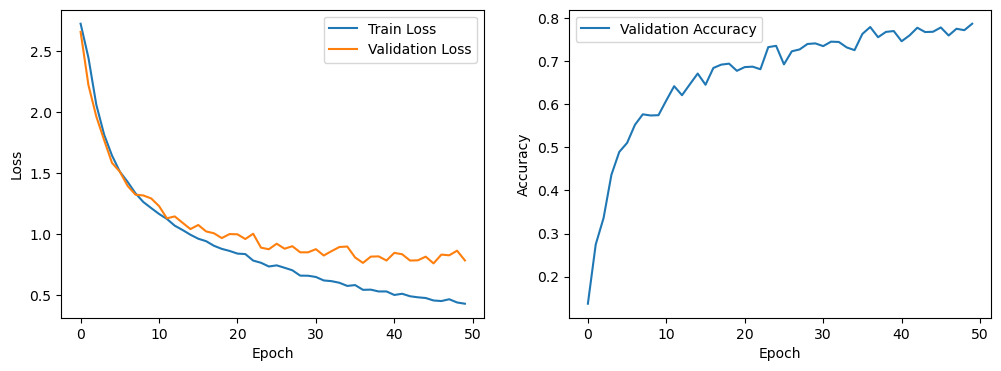

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.23it/s]


Epoch 1, Train Loss: 2.6030852127883395, Validation Loss: 2.2931060642004013, Validation Accuracy: 0.23133333333333334


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.20it/s]


Epoch 2, Train Loss: 2.1247029213582054, Validation Loss: 1.9812063028415043, Validation Accuracy: 0.37066666666666664


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.28it/s]


Epoch 3, Train Loss: 1.846386637728093, Validation Loss: 1.728379746278127, Validation Accuracy: 0.471


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.27it/s]


Epoch 4, Train Loss: 1.5830846883482852, Validation Loss: 1.492166019976139, Validation Accuracy: 0.563


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.29it/s]


Epoch 5, Train Loss: 1.3967161400843475, Validation Loss: 1.378562333683173, Validation Accuracy: 0.5976666666666667


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.22it/s]


Epoch 6, Train Loss: 1.2416702256364338, Validation Loss: 1.1737025504310925, Validation Accuracy: 0.6396666666666667


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.14it/s]


Epoch 7, Train Loss: 1.1170170140468467, Validation Loss: 1.1502995764215787, Validation Accuracy: 0.646


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.22it/s]


Epoch 8, Train Loss: 1.0324668859021138, Validation Loss: 1.0789996633927028, Validation Accuracy: 0.667


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.24it/s]


Epoch 9, Train Loss: 0.9581951347448058, Validation Loss: 1.087919137130181, Validation Accuracy: 0.6626666666666666


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.27it/s]


Epoch 10, Train Loss: 0.8876820550126544, Validation Loss: 0.9368845211962858, Validation Accuracy: 0.708


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.23it/s]


Epoch 11, Train Loss: 0.8333972884436786, Validation Loss: 0.9235598805050055, Validation Accuracy: 0.7086666666666667


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.22it/s]


Epoch 12, Train Loss: 0.76275530255447, Validation Loss: 0.9317109708984693, Validation Accuracy: 0.7146666666666667


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.28it/s]


Epoch 13, Train Loss: 0.7450791905492039, Validation Loss: 0.8640975480278333, Validation Accuracy: 0.7376666666666667


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.26it/s]


Epoch 14, Train Loss: 0.6887341924643112, Validation Loss: 0.8999305584778389, Validation Accuracy: 0.7273333333333334


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.24it/s]


Epoch 15, Train Loss: 0.6823924908698615, Validation Loss: 0.7855632255474726, Validation Accuracy: 0.763


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.29it/s]


Epoch 16, Train Loss: 0.6357835503452915, Validation Loss: 0.7850766933212677, Validation Accuracy: 0.7576666666666667


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.30it/s]


Epoch 17, Train Loss: 0.5910595311956891, Validation Loss: 0.765902808556954, Validation Accuracy: 0.7613333333333333


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.28it/s]


Epoch 18, Train Loss: 0.5717191605244653, Validation Loss: 0.7890586238354445, Validation Accuracy: 0.762


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.27it/s]


Epoch 19, Train Loss: 0.5411516066830037, Validation Loss: 0.7599026871224245, Validation Accuracy: 0.7696666666666667


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.28it/s]


Epoch 20, Train Loss: 0.5045874098599967, Validation Loss: 0.781921853000919, Validation Accuracy: 0.7643333333333333


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.10it/s]


Epoch 21, Train Loss: 0.4945299190989995, Validation Loss: 0.7006163572271665, Validation Accuracy: 0.784


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.24it/s]


Epoch 22, Train Loss: 0.4755653711193699, Validation Loss: 0.7361526961127917, Validation Accuracy: 0.776


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.29it/s]


Epoch 23, Train Loss: 0.4500469999798274, Validation Loss: 0.7294968459755182, Validation Accuracy: 0.781


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.29it/s]


Epoch 24, Train Loss: 0.43786007241677427, Validation Loss: 0.7410323979953924, Validation Accuracy: 0.7753333333333333


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.28it/s]


Epoch 25, Train Loss: 0.410528880559792, Validation Loss: 0.7131158001720905, Validation Accuracy: 0.7963333333333333


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.27it/s]


Epoch 26, Train Loss: 0.3960879222821381, Validation Loss: 0.7044327097634474, Validation Accuracy: 0.7883333333333333


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.29it/s]


Epoch 27, Train Loss: 0.3683301502112615, Validation Loss: 0.8136786750207344, Validation Accuracy: 0.7736666666666666


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.27it/s]


Epoch 28, Train Loss: 0.3661337771405608, Validation Loss: 0.6802062227701148, Validation Accuracy: 0.8083333333333333


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.29it/s]


Epoch 29, Train Loss: 0.32705272746793296, Validation Loss: 0.6963644431283077, Validation Accuracy: 0.8053333333333333


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.31it/s]


Epoch 30, Train Loss: 0.3270172561376782, Validation Loss: 0.6885165267934402, Validation Accuracy: 0.801


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.26it/s]


Epoch 31, Train Loss: 0.3397737353787584, Validation Loss: 0.6271617679546276, Validation Accuracy: 0.8223333333333334


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.24it/s]


Epoch 32, Train Loss: 0.30574265905356, Validation Loss: 0.6195990933726231, Validation Accuracy: 0.8313333333333334


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.25it/s]


Epoch 33, Train Loss: 0.27909344409481956, Validation Loss: 0.703796066964666, Validation Accuracy: 0.8103333333333333


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.23it/s]


Epoch 34, Train Loss: 0.26314269915475685, Validation Loss: 0.6810621634746591, Validation Accuracy: 0.8186666666666667


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.26it/s]


Epoch 35, Train Loss: 0.26370250572592524, Validation Loss: 0.660333231712381, Validation Accuracy: 0.8213333333333334


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.22it/s]


Epoch 36, Train Loss: 0.24969954637147612, Validation Loss: 0.6772053337966403, Validation Accuracy: 0.818


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.24it/s]


Epoch 37, Train Loss: 0.24945260230767524, Validation Loss: 0.6395545589427153, Validation Accuracy: 0.8316666666666667


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.19it/s]


Epoch 38, Train Loss: 0.2335446722552938, Validation Loss: 0.6512431033576528, Validation Accuracy: 0.834


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.95it/s]


Epoch 39, Train Loss: 0.22464862617395692, Validation Loss: 0.6501879431307316, Validation Accuracy: 0.8356666666666667


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  5.95it/s]


Epoch 40, Train Loss: 0.22064933054527994, Validation Loss: 0.6491177324205637, Validation Accuracy: 0.8366666666666667


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:20<00:00,  5.85it/s]


Epoch 41, Train Loss: 0.19350372551608894, Validation Loss: 0.6924752090126276, Validation Accuracy: 0.826


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.11it/s]


Epoch 42, Train Loss: 0.20691698252902194, Validation Loss: 0.6473963937411705, Validation Accuracy: 0.8476666666666667


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.01it/s]


Epoch 43, Train Loss: 0.18513967570359424, Validation Loss: 0.7286446259046594, Validation Accuracy: 0.8256666666666667


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.25it/s]


Epoch 44, Train Loss: 0.17722931662100858, Validation Loss: 0.6471464931964874, Validation Accuracy: 0.8396666666666667


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.21it/s]


Epoch 45, Train Loss: 0.1580871288049019, Validation Loss: 0.7065079702685276, Validation Accuracy: 0.8316666666666667


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.18it/s]


Epoch 46, Train Loss: 0.17839553971159255, Validation Loss: 0.69384655294319, Validation Accuracy: 0.8253333333333334


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.27it/s]


Epoch 47, Train Loss: 0.17343089492770575, Validation Loss: 0.6946883869046966, Validation Accuracy: 0.8276666666666667


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.18it/s]


Epoch 48, Train Loss: 0.16604896685329534, Validation Loss: 0.702265502884984, Validation Accuracy: 0.8303333333333334


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.14it/s]


Epoch 49, Train Loss: 0.13940519299673831, Validation Loss: 0.6818003676210841, Validation Accuracy: 0.839


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.04it/s]


Epoch 50, Train Loss: 0.14765076702302796, Validation Loss: 0.7154954286913077, Validation Accuracy: 0.8293333333333334
Patch size: 28, Test Loss: 0.6680032030368844, Test Accuracy: 0.8356666666666667
patch size= 28


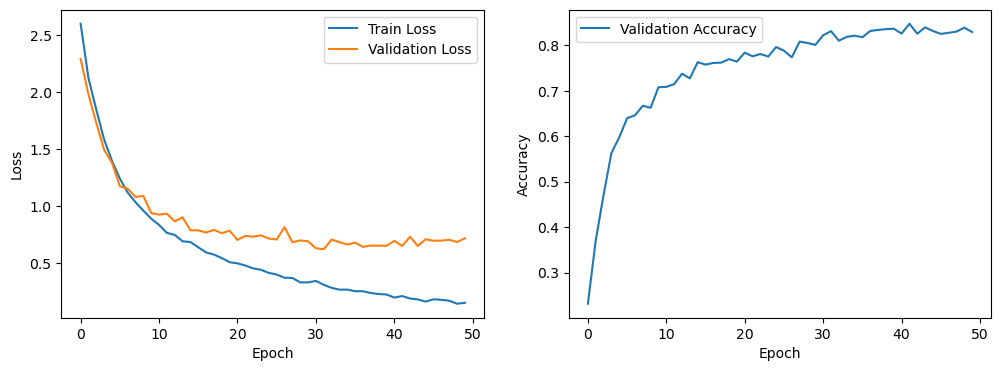

Epoch 1:  35%|█████████████████████████                                               | 41/118 [00:08<00:15,  4.83it/s]


KeyboardInterrupt: 

In [28]:
train_model(m_56,train_loss_56,val_loss_56,val_acc_56,'56')
test_model(m_56,'56')
plt_model(train_loss_56,val_loss_56,val_acc_56,'56')

train_model(m_32,train_loss_32,val_loss_32,val_acc_32,'32')
test_model(m_32,'32')
plt_model(train_loss_32,val_loss_32,val_acc_32,'32')

train_model(m_28,train_loss_28,val_loss_28,val_acc_28,'28')
test_model(m_28,'28')
plt_model(train_loss_28,val_loss_28,val_acc_28,'28')

train_model(m_14,train_loss_14,val_loss_14,val_acc_14,'14')
test_model(m_14,'14')
plt_model(train_loss_14,val_loss_14,val_acc_14,'14')

train_model(m_8,train_loss_8,val_loss_8,val_acc_8,'8')
test_model(m_8,'8')
plt_model(train_loss_8,val_loss_8,val_acc_8,'8')

#save experiment data
print(f'patch size = 8:')
print('train loss:',train_loss_8,'\n')
print('validation loss:',val_loss_8,'\n')
print('validation accuracy:',val_acc_8,'\n','\n')

print(f'patch size = 14:')
print('train loss:',train_loss_14,'\n')
print('validation loss:',val_loss_14,'\n')
print('validation accuracy:',val_acc_14,'\n','\n')

print(f'patch size = 28:')
print('train loss:',train_loss_28,'\n')
print('validation loss:',val_loss_28,'\n')
print('validation accuracy:',val_acc_28,'\n','\n')

print(f'patch size = 32:')
print('train loss:',train_loss_32,'\n')
print('validation loss:',val_loss_32,'\n')
print('validation accuracy:',val_acc_32,'\n','\n')

print(f'patch size = 56:')
print('train loss:',train_loss_56,'\n')
print('validation loss:',val_loss_56,'\n')
print('validation accuracy:',val_acc_56,'\n','\n')

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:09<00:00,  1.69it/s]


Epoch 1, Train Loss: 2.348408583867348, Validation Loss: 1.9569144646326702, Validation Accuracy: 0.373


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.74it/s]


Epoch 2, Train Loss: 1.681159653906095, Validation Loss: 1.5254333193103473, Validation Accuracy: 0.5253333333333333


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.95it/s]


Epoch 3, Train Loss: 1.2818006438724066, Validation Loss: 1.1940595867733161, Validation Accuracy: 0.661


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.92it/s]


Epoch 4, Train Loss: 0.9883638483993078, Validation Loss: 1.0013945947090785, Validation Accuracy: 0.706


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.91it/s]


Epoch 5, Train Loss: 0.7911875101469331, Validation Loss: 0.8537814070781072, Validation Accuracy: 0.7476666666666667


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.87it/s]


Epoch 6, Train Loss: 0.6422852603560787, Validation Loss: 0.7611344009637833, Validation Accuracy: 0.7666666666666667


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.85it/s]


Epoch 7, Train Loss: 0.5219205878043579, Validation Loss: 0.6018372538189093, Validation Accuracy: 0.8293333333333334


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.89it/s]


Epoch 8, Train Loss: 0.41208656258502246, Validation Loss: 0.5880193179473281, Validation Accuracy: 0.8223333333333334


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.92it/s]


Epoch 9, Train Loss: 0.3506454522326841, Validation Loss: 0.6314313001930714, Validation Accuracy: 0.806


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.98it/s]


Epoch 10, Train Loss: 0.2890663293458648, Validation Loss: 0.46983980884154636, Validation Accuracy: 0.8636666666666667


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.93it/s]


Epoch 11, Train Loss: 0.24639475560289317, Validation Loss: 0.45761152853568393, Validation Accuracy: 0.866


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.84it/s]


Epoch 12, Train Loss: 0.21074552297339602, Validation Loss: 0.46415512325863045, Validation Accuracy: 0.8663333333333333


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.02it/s]


Epoch 13, Train Loss: 0.1705947477938765, Validation Loss: 0.36667769697184366, Validation Accuracy: 0.8976666666666666


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.07it/s]


Epoch 14, Train Loss: 0.11952254270850601, Validation Loss: 0.4777279409269492, Validation Accuracy: 0.866


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:38<00:00,  3.09it/s]


Epoch 15, Train Loss: 0.11191763220575907, Validation Loss: 0.4359339904040098, Validation Accuracy: 0.881


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:33<00:00,  3.52it/s]


Epoch 16, Train Loss: 0.10174421078951681, Validation Loss: 0.38678612746298313, Validation Accuracy: 0.8956666666666667


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:38<00:00,  3.10it/s]


Epoch 17, Train Loss: 0.09897998381027226, Validation Loss: 0.4256200014303128, Validation Accuracy: 0.8873333333333333


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.96it/s]


Epoch 18, Train Loss: 0.05801130190365395, Validation Loss: 0.36664904188364744, Validation Accuracy: 0.9066666666666666


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.82it/s]


Epoch 19, Train Loss: 0.05090992872492742, Validation Loss: 0.3675574706867337, Validation Accuracy: 0.9026666666666666


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.11it/s]


Epoch 20, Train Loss: 0.07187642955805286, Validation Loss: 0.3879020990182956, Validation Accuracy: 0.9013333333333333


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.99it/s]


Epoch 21, Train Loss: 0.06238140872979568, Validation Loss: 0.35819821152836084, Validation Accuracy: 0.9056666666666666


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.01it/s]


Epoch 22, Train Loss: 0.045534135023984366, Validation Loss: 0.6079341994288067, Validation Accuracy: 0.849


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.90it/s]


Epoch 23, Train Loss: 0.12359566591932612, Validation Loss: 0.37652619803945225, Validation Accuracy: 0.8973333333333333


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.07it/s]


Epoch 24, Train Loss: 0.03538945138896421, Validation Loss: 0.3382627855365475, Validation Accuracy: 0.9176666666666666


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.16it/s]


Epoch 25, Train Loss: 0.012589003200153425, Validation Loss: 0.3456214675679803, Validation Accuracy: 0.918


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.97it/s]


Epoch 26, Train Loss: 0.004659939754628024, Validation Loss: 0.3181904296701153, Validation Accuracy: 0.926


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  4.98it/s]


Epoch 27, Train Loss: 0.003140067343276499, Validation Loss: 0.32578713617598015, Validation Accuracy: 0.9256666666666666


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.11it/s]


Epoch 28, Train Loss: 0.002641297574944289, Validation Loss: 0.3227387916607161, Validation Accuracy: 0.927


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.18it/s]


Epoch 29, Train Loss: 0.002284611584677882, Validation Loss: 0.32311663365301985, Validation Accuracy: 0.9263333333333333


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.21it/s]


Epoch 30, Train Loss: 0.002047466255242984, Validation Loss: 0.3247686655571063, Validation Accuracy: 0.9253333333333333


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.10it/s]


Epoch 31, Train Loss: 0.0018362603761981856, Validation Loss: 0.3270995429872225, Validation Accuracy: 0.9263333333333333


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.17it/s]


Epoch 32, Train Loss: 0.0016848147793483558, Validation Loss: 0.3271432909338425, Validation Accuracy: 0.9256666666666666


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.17it/s]


Epoch 33, Train Loss: 0.0015274671447005565, Validation Loss: 0.3291788672407468, Validation Accuracy: 0.9253333333333333


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.17it/s]


Epoch 34, Train Loss: 0.0013926651282433293, Validation Loss: 0.3326729453013589, Validation Accuracy: 0.926


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.16it/s]


Epoch 35, Train Loss: 0.001282661726552267, Validation Loss: 0.3311140610991667, Validation Accuracy: 0.9273333333333333


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.16it/s]


Epoch 36, Train Loss: 0.0011789593278327798, Validation Loss: 0.3285771905599783, Validation Accuracy: 0.9263333333333333


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.13it/s]


Epoch 37, Train Loss: 0.0010864447355388774, Validation Loss: 0.33307606882105273, Validation Accuracy: 0.9266666666666666


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.02it/s]


Epoch 38, Train Loss: 0.0010093808992000265, Validation Loss: 0.33611279850204784, Validation Accuracy: 0.9263333333333333


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.19it/s]


Epoch 39, Train Loss: 0.0009270478824303501, Validation Loss: 0.3343696988498171, Validation Accuracy: 0.927


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.15it/s]


Epoch 40, Train Loss: 0.0008581994265175851, Validation Loss: 0.3381971458438784, Validation Accuracy: 0.9266666666666666


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.08it/s]


Epoch 41, Train Loss: 0.0007959766741605255, Validation Loss: 0.33915452325406176, Validation Accuracy: 0.9256666666666666


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.12it/s]


Epoch 42, Train Loss: 0.0007434907286443701, Validation Loss: 0.34054669745576877, Validation Accuracy: 0.9256666666666666


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:22<00:00,  5.16it/s]


Epoch 43, Train Loss: 0.000687437084645538, Validation Loss: 0.3428262259500722, Validation Accuracy: 0.9256666666666666


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.08it/s]


Epoch 44, Train Loss: 0.0006397306190022283, Validation Loss: 0.34333802325030166, Validation Accuracy: 0.9243333333333333


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.88it/s]


Epoch 45, Train Loss: 0.0005987007484151745, Validation Loss: 0.3447101388592273, Validation Accuracy: 0.926


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.92it/s]


Epoch 46, Train Loss: 0.0005518285319864182, Validation Loss: 0.3500137694645673, Validation Accuracy: 0.927


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.82it/s]


Epoch 47, Train Loss: 0.0005144912799350696, Validation Loss: 0.3446936052447806, Validation Accuracy: 0.927


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:24<00:00,  4.91it/s]


Epoch 48, Train Loss: 0.0004755870896140982, Validation Loss: 0.3489622638250391, Validation Accuracy: 0.9276666666666666


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:23<00:00,  5.07it/s]


Epoch 49, Train Loss: 0.0004463650136238943, Validation Loss: 0.35008182702586055, Validation Accuracy: 0.928


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [00:25<00:00,  4.57it/s]


Epoch 50, Train Loss: 0.0004206505915844592, Validation Loss: 0.35354691192818183, Validation Accuracy: 0.9266666666666666
Patch size: 14, Test Loss: 0.34291515685617924, Test Accuracy: 0.9256666666666666
patch size= 14


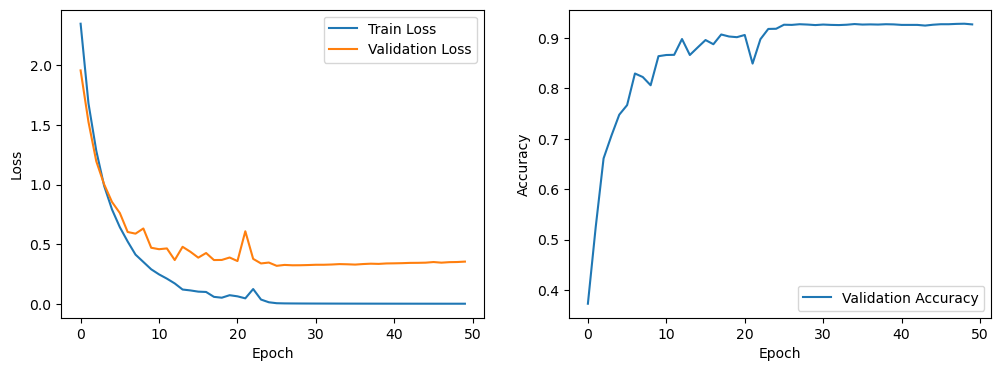

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:05<00:00,  1.79it/s]


Epoch 1, Train Loss: 2.1806350158432783, Validation Loss: 1.7952429751555126, Validation Accuracy: 0.43033333333333335


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch 2, Train Loss: 1.6006073072805242, Validation Loss: 1.4721485301852226, Validation Accuracy: 0.519


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch 3, Train Loss: 1.3169574242527202, Validation Loss: 1.2462646812200546, Validation Accuracy: 0.5986666666666667


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch 4, Train Loss: 1.0789132183891232, Validation Loss: 1.1184935420751572, Validation Accuracy: 0.653


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:00<00:00,  1.95it/s]


Epoch 5, Train Loss: 0.8987104882628231, Validation Loss: 0.9122345522046089, Validation Accuracy: 0.7183333333333334


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch 6, Train Loss: 0.7602420479564344, Validation Loss: 0.9015041862924894, Validation Accuracy: 0.715


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch 7, Train Loss: 0.6334915648577577, Validation Loss: 0.7441349451740583, Validation Accuracy: 0.7676666666666667


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:05<00:00,  1.79it/s]


Epoch 8, Train Loss: 0.5288639707585513, Validation Loss: 0.6518188727398714, Validation Accuracy: 0.796


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch 9, Train Loss: 0.4276202390507116, Validation Loss: 0.5733965703596672, Validation Accuracy: 0.8283333333333334


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 10, Train Loss: 0.3431972245038566, Validation Loss: 0.565937975111107, Validation Accuracy: 0.8263333333333334


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 11, Train Loss: 0.2770660063725407, Validation Loss: 0.50566301929454, Validation Accuracy: 0.853


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch 12, Train Loss: 0.22463698161102957, Validation Loss: 0.5431581869100531, Validation Accuracy: 0.842


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 13, Train Loss: 0.19175355215320142, Validation Loss: 0.5222660178939501, Validation Accuracy: 0.857


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch 14, Train Loss: 0.1112098405611212, Validation Loss: 0.5509651647880673, Validation Accuracy: 0.8426666666666667


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch 15, Train Loss: 0.08604167717493187, Validation Loss: 0.46494838036596775, Validation Accuracy: 0.8723333333333333


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch 16, Train Loss: 0.06647169692599672, Validation Loss: 0.532339172748228, Validation Accuracy: 0.864


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 17, Train Loss: 0.059384353222104454, Validation Loss: 0.47688766817251843, Validation Accuracy: 0.875


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 18, Train Loss: 0.028361816132851575, Validation Loss: 0.46757862499604624, Validation Accuracy: 0.886


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch 19, Train Loss: 0.025849821882606563, Validation Loss: 0.4476111883608003, Validation Accuracy: 0.89


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch 20, Train Loss: 0.012353586372366901, Validation Loss: 0.4366581846649448, Validation Accuracy: 0.893


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch 21, Train Loss: 0.006156564473127157, Validation Loss: 0.4782757787227941, Validation Accuracy: 0.8866666666666667


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch 22, Train Loss: 0.004797719453532501, Validation Loss: 0.4323248035895328, Validation Accuracy: 0.8973333333333333


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch 23, Train Loss: 0.0022671447851758263, Validation Loss: 0.44129143794998527, Validation Accuracy: 0.898


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:00<00:00,  1.95it/s]


Epoch 24, Train Loss: 0.0018394867972455035, Validation Loss: 0.43896331762274104, Validation Accuracy: 0.9006666666666666


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch 25, Train Loss: 0.0016072407045196425, Validation Loss: 0.4331351697910577, Validation Accuracy: 0.9016666666666666


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:04<00:00,  1.84it/s]


Epoch 26, Train Loss: 0.0013512400012479116, Validation Loss: 0.43266947171650827, Validation Accuracy: 0.9016666666666666


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch 27, Train Loss: 0.0011779133914141143, Validation Loss: 0.43350088813652593, Validation Accuracy: 0.901


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:05<00:00,  1.81it/s]


Epoch 28, Train Loss: 0.0010491526015773732, Validation Loss: 0.4360414919598649, Validation Accuracy: 0.9013333333333333


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch 29, Train Loss: 0.0009380226991320881, Validation Loss: 0.43715223817465204, Validation Accuracy: 0.902


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:04<00:00,  1.84it/s]


Epoch 30, Train Loss: 0.0008449432833743739, Validation Loss: 0.43485483053761226, Validation Accuracy: 0.9026666666666666


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:04<00:00,  1.83it/s]


Epoch 31, Train Loss: 0.0007627557117641919, Validation Loss: 0.43884809377292794, Validation Accuracy: 0.9023333333333333


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:04<00:00,  1.83it/s]


Epoch 32, Train Loss: 0.0006888381021010484, Validation Loss: 0.4400623207911849, Validation Accuracy: 0.903


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch 33, Train Loss: 0.0006240646508265823, Validation Loss: 0.43909022289638716, Validation Accuracy: 0.9046666666666666


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch 34, Train Loss: 0.0005683358968334209, Validation Loss: 0.44052306182372075, Validation Accuracy: 0.9053333333333333


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch 35, Train Loss: 0.0005155430233078393, Validation Loss: 0.4445778711233288, Validation Accuracy: 0.904


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:01<00:00,  1.90it/s]


Epoch 36, Train Loss: 0.00046974098555530594, Validation Loss: 0.4412223962135613, Validation Accuracy: 0.9053333333333333


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 37, Train Loss: 0.00042851650160027004, Validation Loss: 0.44307864729004603, Validation Accuracy: 0.905


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:05<00:00,  1.81it/s]


Epoch 38, Train Loss: 0.00039112357219475935, Validation Loss: 0.4413674669728304, Validation Accuracy: 0.905


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch 39, Train Loss: 0.0003585569472723025, Validation Loss: 0.4449326967975746, Validation Accuracy: 0.9073333333333333


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 40, Train Loss: 0.00032825312999933484, Validation Loss: 0.4423168932941432, Validation Accuracy: 0.906


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch 41, Train Loss: 0.0003005926231153199, Validation Loss: 0.4468100039133181, Validation Accuracy: 0.9076666666666666


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [05:46<00:00,  2.94s/it]


Epoch 42, Train Loss: 0.00027620282122308896, Validation Loss: 0.44787435450901586, Validation Accuracy: 0.9073333333333333


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch 43, Train Loss: 0.00025375323987692215, Validation Loss: 0.44778675710161525, Validation Accuracy: 0.9073333333333333


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 44, Train Loss: 0.00023320336629818116, Validation Loss: 0.4464050920214504, Validation Accuracy: 0.908


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 45, Train Loss: 0.00021481924390388747, Validation Loss: 0.4475925190684696, Validation Accuracy: 0.9076666666666666


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch 46, Train Loss: 0.000197034212267342, Validation Loss: 0.44906228811790544, Validation Accuracy: 0.91


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch 47, Train Loss: 0.00018082142073041522, Validation Loss: 0.44886588390606147, Validation Accuracy: 0.9076666666666666


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch 48, Train Loss: 0.00016603924573785862, Validation Loss: 0.4516406621551141, Validation Accuracy: 0.909


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch 49, Train Loss: 0.0001536028693238731, Validation Loss: 0.4508401909455036, Validation Accuracy: 0.9093333333333333


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:05<00:00,  1.80it/s]


Epoch 50, Train Loss: 0.0001406766625562233, Validation Loss: 0.4506945716372381, Validation Accuracy: 0.91
Patch size: 8, Test Loss: 0.42545741458889097, Test Accuracy: 0.9036666666666666
patch size= 8


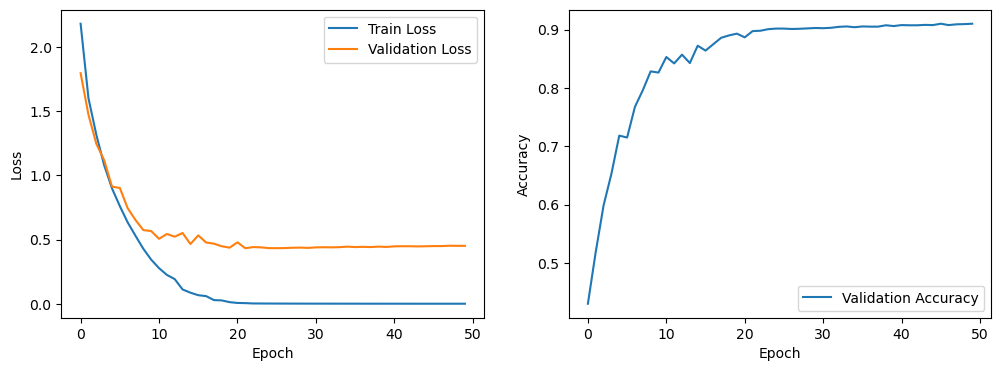

patch size = 8:
train loss: [2.1806350158432783, 1.6006073072805242, 1.3169574242527202, 1.0789132183891232, 0.8987104882628231, 0.7602420479564344, 0.6334915648577577, 0.5288639707585513, 0.4276202390507116, 0.3431972245038566, 0.2770660063725407, 0.22463698161102957, 0.19175355215320142, 0.1112098405611212, 0.08604167717493187, 0.06647169692599672, 0.059384353222104454, 0.028361816132851575, 0.025849821882606563, 0.012353586372366901, 0.006156564473127157, 0.004797719453532501, 0.0022671447851758263, 0.0018394867972455035, 0.0016072407045196425, 0.0013512400012479116, 0.0011779133914141143, 0.0010491526015773732, 0.0009380226991320881, 0.0008449432833743739, 0.0007627557117641919, 0.0006888381021010484, 0.0006240646508265823, 0.0005683358968334209, 0.0005155430233078393, 0.00046974098555530594, 0.00042851650160027004, 0.00039112357219475935, 0.0003585569472723025, 0.00032825312999933484, 0.0003005926231153199, 0.00027620282122308896, 0.00025375323987692215, 0.00023320336629818116, 0.

In [15]:
train_model(m_14,train_loss_14,val_loss_14,val_acc_14,'14')
test_model(m_14,'14')
plt_model(train_loss_14,val_loss_14,val_acc_14,'14')

train_model(m_8,train_loss_8,val_loss_8,val_acc_8,'8')
test_model(m_8,'8')
plt_model(train_loss_8,val_loss_8,val_acc_8,'8')

#save experiment data
print(f'patch size = 8:')
print('train loss:',train_loss_8,'\n')
print('validation loss:',val_loss_8,'\n')
print('validation accuracy:',val_acc_8,'\n','\n')

print(f'patch size = 14:')
print('train loss:',train_loss_14,'\n')
print('validation loss:',val_loss_14,'\n')
print('validation accuracy:',val_acc_14,'\n','\n')

print(f'patch size = 28:')
print('train loss:',train_loss_28,'\n')
print('validation loss:',val_loss_28,'\n')
print('validation accuracy:',val_acc_28,'\n','\n')

print(f'patch size = 32:')
print('train loss:',train_loss_32,'\n')
print('validation loss:',val_loss_32,'\n')
print('validation accuracy:',val_acc_32,'\n','\n')

print(f'patch size = 56:')
print('train loss:',train_loss_56,'\n')
print('validation loss:',val_loss_56,'\n')
print('validation accuracy:',val_acc_56,'\n','\n')

# Base Model with Data Argumentation

In [49]:
model_da=MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 14,
    dim = 196,
    depth = 2,
    num_classes = 15
)
model_da.to(device)

Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=14, p2=14)
  (1): Linear(in_features=588, out_features=196, bias=True)
  (2): Sequential(
    (0): PreNormResidual(
      (fn): Sequential(
        (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
    )
    (1): PreNormResidual(
      (fn): Sequential(
        (0): Linear(in_features=196, out_features=98, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=98, out_features=196, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
    )
  )
  (3): Sequential(
    (0): PreNormResidual(
      (fn): Sequential(

In [50]:
train_losses_da = []
val_losses_da = []
val_accuracies_da = []


In [51]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# data directory
data_dir = './Dataset'

# data preprocessing and argumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# training set
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)

# test set
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)

# validation set
validation_dataset = datasets.ImageFolder(root=data_dir + '/validation', transform=transform)

# data loader
batch_size = 128  # based on hardware
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [52]:
num_epochs=20
criterion = nn.CrossEntropyLoss()
cur_lr=0.001
optimizer = optim.Adam(model_da.parameters(), lr=cur_lr)
for epoch in range(num_epochs):
    """
    if num_epochs % 10 == 0:
      cur_lr/=2
      optimizer = optim.Adam(model_da.parameters(), lr=cur_lr)
    """
    model_da.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()

        images, labels = images.to(device), labels.to(device)
        outputs = model_da(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # validation loss and validation acc
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        model_da.eval()
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_da(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_losses_da.append(running_loss / len(train_loader))
    val_losses_da.append(val_loss / len(validation_loader))
    val_accuracies_da.append(val_correct / val_total)

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses_da[-1]}, Validation Loss: {val_losses_da[-1]}, Validation Accuracy: {val_accuracies_da[-1]}')

    # 保存训练后的模型
    torch.save(model_da.state_dict(), 'mlp_mixer_da_vegetables.pth')


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:30<00:00,  1.30it/s]


Epoch 1, Train Loss: 1.5942668141955036, Validation Loss: 1.2152506423493226, Validation Accuracy: 0.5786666666666667


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:29<00:00,  1.32it/s]


Epoch 2, Train Loss: 0.9785142242908478, Validation Loss: 0.8951729871332645, Validation Accuracy: 0.709


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:27<00:00,  1.35it/s]


Epoch 3, Train Loss: 0.7760360397524753, Validation Loss: 0.682246937106053, Validation Accuracy: 0.7763333333333333


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:28<00:00,  1.34it/s]


Epoch 4, Train Loss: 0.6305750454381361, Validation Loss: 0.5804968985418478, Validation Accuracy: 0.8156666666666667


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:28<00:00,  1.34it/s]


Epoch 5, Train Loss: 0.548109116443133, Validation Loss: 0.5620766958842675, Validation Accuracy: 0.8223333333333334


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:28<00:00,  1.33it/s]


Epoch 6, Train Loss: 0.4863204058196585, Validation Loss: 0.49861918700238067, Validation Accuracy: 0.8486666666666667


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:22<00:00,  1.42it/s]


Epoch 7, Train Loss: 0.4561227134476274, Validation Loss: 0.5167489275336266, Validation Accuracy: 0.844


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:23<00:00,  1.42it/s]


Epoch 8, Train Loss: 0.42175649573742335, Validation Loss: 0.4735150911534826, Validation Accuracy: 0.8453333333333334


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 118/118 [01:25<00:00,  1.38it/s]


Epoch 9, Train Loss: 0.3876467311786393, Validation Loss: 0.37349998982002336, Validation Accuracy: 0.878


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:24<00:00,  1.39it/s]


Epoch 10, Train Loss: 0.35920553629176094, Validation Loss: 0.3419394150065879, Validation Accuracy: 0.889


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:23<00:00,  1.42it/s]


Epoch 11, Train Loss: 0.31679245349714313, Validation Loss: 0.32826838029238087, Validation Accuracy: 0.8993333333333333


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:25<00:00,  1.38it/s]


Epoch 12, Train Loss: 0.31704663737850675, Validation Loss: 0.3344274864066392, Validation Accuracy: 0.8976666666666666


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:24<00:00,  1.39it/s]


Epoch 13, Train Loss: 0.3217862112037206, Validation Loss: 0.33409474107126397, Validation Accuracy: 0.8916666666666667


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:24<00:00,  1.39it/s]


Epoch 14, Train Loss: 0.28660834189188683, Validation Loss: 0.29966805735602975, Validation Accuracy: 0.9106666666666666


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:23<00:00,  1.41it/s]


Epoch 15, Train Loss: 0.27387194853212876, Validation Loss: 0.2985841433207194, Validation Accuracy: 0.907


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:23<00:00,  1.41it/s]


Epoch 16, Train Loss: 0.2671471887852176, Validation Loss: 0.2934013338914762, Validation Accuracy: 0.903


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:23<00:00,  1.41it/s]


Epoch 17, Train Loss: 0.26200924415962173, Validation Loss: 0.25920850069572526, Validation Accuracy: 0.916


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:29<00:00,  1.32it/s]


Epoch 18, Train Loss: 0.253649771276672, Validation Loss: 0.23609171260613948, Validation Accuracy: 0.9226666666666666


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:26<00:00,  1.36it/s]


Epoch 19, Train Loss: 0.23704179793091143, Validation Loss: 0.2398562819386522, Validation Accuracy: 0.927


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 118/118 [01:33<00:00,  1.27it/s]


Epoch 20, Train Loss: 0.2364368134383428, Validation Loss: 0.3070991944211225, Validation Accuracy: 0.9006666666666666


In [1]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Without data augmentation")
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(num_epochs))
plt.legend()

plt.subplot(1, 2, 2)
plt.title("With data augmentation")
plt.plot(range(num_epochs), train_losses_da, label='Train Loss')
plt.plot(range(num_epochs), val_losses_da, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(num_epochs))
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [74]:

# load model weight
model_da_test = MLPMixer(
    image_size = (224, 224),
    channels = 3,
    patch_size = 14,
    dim = 196,
    depth = 2,
    num_classes = 15
)

model_da_test.load_state_dict(torch.load('./mlp_mixer_da_vegetables.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_da_test.to(device)

model_da_test.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_da_test(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy}')


Test Loss: 0.29692839303364355, Test Accuracy: 0.911
